# Poisson Package
#### For Neural-Network-Related Methods of Solving Differential Equations
Laplace @UBC 2024

Department of Physics & Astronomy

In [1]:
#Basic Definitions:

import torch


def D(f, wrt, n=1):
    """
    Calculates the df/dwrt, in the order of n
    """
    f = f.sum()
    grads = torch.autograd.grad(f, wrt, create_graph=True, allow_unused=True)[0]
    
    for i in range(n-1):
        #print("here")
        grads = torch.autograd.grad(grads.sum(), wrt, create_graph=True,retain_graph=True , allow_unused=True)[0]

    return grads.reshape(-1,1)
 

## Animator Method

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from IPython.display import HTML

def animator(functions, x=None, save_path=None):
    """
    Create an animation to visualize a list of functions.

    Args:
    functions (torch.Tensor or list of torch.Tensor): List of functions to visualize.
    x (torch.Tensor, optional): X-axis values corresponding to the functions.
    save_path (str, optional): If provided, save the animation as a GIF to this path.

    Returns:
    HTML: An HTML object displaying the animation.
    """
    
    # Transpose the input functions if necessary
    if isinstance(functions, torch.Tensor):
        functions = functions.t()

    # Convert functions to a list of numpy arrays
    functions = [func.detach().numpy() for func in functions]

    # Calculate the maximum y_range across all functions
    max_y_range = max(np.max(func) - np.min(func) for func in functions)

    fig, ax = plt.subplots()
    
    ax.set_ylim(0, np.max([np.max(func) for func in functions]) + max_y_range)
    ax.set_xlim(0, len(functions[0]))

    def update(frame):
        ax.clear()
        ax.plot(functions[frame])
        ax.set_title(f'Frame {frame}')

    ani = animation.FuncAnimation(fig, update, frames=len(functions), interval=200)

    # Save the animation as a GIF if a save_path is provided
    if save_path:
        ani.save(save_path, writer='pillow')

    # Display the animation in the notebook
    return HTML(ani.to_jshtml())


## Scientific Plot

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import cycle

def create_scientific_plot(x, y_sets, labels, title, x_label, y_label, save_plot=False, dpi=300, color=False, line_style=False, marker_size=5):
    # Set the font to LaTeX default font
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"  # You can also use 'sans-serif' for a sans-serif font

    # Create a figure with a single subplot
    fig, ax = plt.subplots(dpi=dpi)

    # Define different shades of gray
    gray_colors = ["#555555", "#777777", "#999999", "#CCCCCC"]

    # Define line styles
    line_styles = ['-', '--', '-.', ':']
    line_cycle = cycle(line_styles)
    line_cycle_for_style = cycle(line_styles) if line_style else cycle(['-'])

    # Define custom color map with distinct colors (Pastel Colors)
    pastel_colors = ["#FF6B6B", "#FFD166", "#06D6A0", "#118AB2", "#073B4C", "#BC6FF1", "#F09D51", "#FFD6A0", "#7B82DA", "#A9A9A9"]
    color_cycle = cycle(pastel_colors)

    # Plot each set of data
    for i, (y, label) in enumerate(zip(y_sets, labels)):
        if color:
            plot_color = next(color_cycle)
        else:
            plot_color = gray_colors[i % len(gray_colors)]
        if line_style:
            line_style = next(line_cycle_for_style)
        else:
            line_style = next(line_cycle)
        ax.plot(x, y, marker='o', markersize=marker_size, linestyle=line_style, linewidth=2, label=label, color=plot_color)

    # Customize the plot
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)

    # Customize the title
    ax.set_title(r'\textbf{' + title + '}', fontsize=16)  # Make it bold and larger

    # Add grid lines
    ax.grid(color='gray', linestyle='--', linewidth=0.5)

    # Customize the axis ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer tick marks on x-axis

    #Scale
    # ax.set_yscale("log")

    # ax.yaxis.get_major_formatter().set_useOffset(True)


    # Customize legend
    ax.legend(fontsize=10)

    # Save the plot as a PNG if save_plot is True
    if save_plot:
        if isinstance(save_plot, str):
            filename = save_plot + '.png'
        else:
            filename = title + '.png'
        plt.savefig(filename, format='png', bbox_inches='tight', dpi=dpi)

    # Display the plot
    plt.show()


# # Example usage with color set to True and line_style set to True
# x = np.linspace(0, 10, 20)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = 2*np.sin(x)
# labels = ['Sine Function', 'Cosine Function', 'Tangent Function']
# create_scientific_plot(x, [y1, y2, y3], labels, 'Trigonometric Functions', 'Time (s)', 'Amplitude', save_plot=True, dpi=300, color=True, line_style=True)

# # Example usage with color set to True and line_style set to False
# create_scientific_plot(x, [y1, y2, y3], labels, 'Trigonometric Functions', 'Time (s)', 'Amplitude', save_plot=True, dpi=300, color=True, line_style=False)

# # Example usage with color set to False and line_style set to True
# create_scientific_plot(x, [y1, y2, y3], labels, 'Trigonometric Functions', 'Time (s)', 'Amplitude', save_plot=True, dpi=300, color=False, line_style=True)

# # Example usage with color set to False and line_style set to False
# create_scientific_plot(x, [y1, y2, y3], labels, 'Trigonometric Functions', 'Time (s)', 'Amplitude', save_plot=True, dpi=300, color=False, line_style=False)


## Solver Model Class 

In [4]:
import torch
import torch.optim as optim
from scipy.sparse.linalg import gmres
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

class EDNNSolver:
    def __init__(self, model, Pi, IC, N, exactanswer, num_points=500, left_boundary=-1.0, right_boundary=1.0,
                 dt=0.001, final_time=1.0, num_epochs=15000, learning_rate=0.0001,
                 print_interval=100, device="cpu", evol_method="Euler",save_all_functions=False,init_print_number=5,
                 tol=1e-5):
        self.num_points = num_points
        self.left_boundary = left_boundary
        self.right_boundary = right_boundary
        self.dt = dt
        self.final_time = final_time
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.print_interval = print_interval
        self.device = device
        self.evol_method = evol_method  # Choose between "RK4" and "Euler"

        self.Model = model.to(self.device)
        self.criterion = torch.nn.MSELoss()
        # self.optimizer = optim.Adam(self.Model.parameters(), lr=self.learning_rate)
        self.IC = IC
        self.N = N
        self.exactanswer = exactanswer
        self.errors = torch.tensor([],device=self.device)  # Store errors over time
        self.X = torch.linspace(self.left_boundary, self.right_boundary, self.num_points, requires_grad=True, device=self.device).view(-1, 1)
        self.num_parameters=sum(p.numel() for p in self.Model.parameters())
        self.save_all_functions=save_all_functions
        self.initial_error=0
        self.init_print_number=init_print_number
        self.tol=tol
        self.Pi=Pi
        # self.loss = []

    
    def initialize(self,Model=None,Target=None):
        if Model is None:
            Model=self.Model
        if Target is None:
            Target=self.IC

        print("==========Initialization===========")

        self.losses = []
        optimizer = optim.Adam(Model.parameters(), lr=self.learning_rate)

        # X = torch.linspace(self.left_boundary, self.right_boundary, self.num_points, requires_grad=True, device=self.device).view(-1, 1)
        for epoch in range(self.num_epochs):
            loss = torch.sqrt(self.criterion(Model(self.X), Target(self.X)))
            self.losses.append(loss.item())
            # print(self.losses)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (epoch + 1) % (self.num_epochs / self.init_print_number) == 0:
                plt.plot(self.X.detach().numpy(),Model(self.X).detach().numpy())
                plt.plot(self.X.detach().numpy(),Target(self.X).detach().numpy(),'r--')
                plt.show()
                plt.plot(self.losses[:])
                plt.yscale("log")
                plt.show()
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item()}')
        
        error=torch.sqrt(self.criterion(Model(self.X), Target(self.X)))
        # error = torch.linalg.vector_norm(self.IC(self.X) - self.Model(self.X), ord=2)
        print("Initial Error =", error.item())
        self.initial_error = error.item()
        # self.errors.append((0.0, error.item()))  # Store initial error
        plt.plot(self.X.detach().numpy(),Model(self.X).detach().numpy())
        plt.show()
        print("====================================")

    def evolve(self):
        time_steps = int(self.final_time / self.dt)
        # X = torch.linspace(self.left_boundary, self.right_boundary, self.num_points, requires_grad=True, device=self.device).view(-1, 1)

        self.functions = torch.tensor([], device=self.device)
        self.plot_times = torch.tensor([], device=self.device)
        self.localerrors = torch.tensor([], device=self.device)

        #Initial Error, Function, and time
        self.errors=torch.tensor([])
        t=0
        error=torch.sqrt(self.criterion(self.Model(self.X), self.exactanswer(self.X,torch.tensor([t]))))
        self.errors=torch.cat((self.errors,error.view(1)),0)
        self.functions = torch.cat((self.functions, self.Model(self.X)), 1)
        self.plot_times = torch.cat((self.plot_times, torch.tensor([0])), 0)


        for time_step in tqdm(range(1, time_steps + 1), desc="Evolving The Solution", ncols=100):
            t = time_step * self.dt

            if self.evol_method == "RK4":
                k_1 = self.calculate_gamma_opt(self.Model, torch.zeros((self.num_parameters, 1), device=self.device))
                k_2 = self.calculate_gamma_opt(self.Model, k_1 / 2)
                k_3 = self.calculate_gamma_opt(self.Model, k_2 / 2)
                k_4 = self.calculate_gamma_opt(self.Model, k_3)

                column_vector_to_add = (k_1 / 6 + k_2 / 3 + k_3 / 3 + k_4 / 6) * self.dt

            elif self.evol_method == "Euler":
                gamma_opt = self.calculate_gamma_opt(self.Pi,RHS=self.N(self.Model(self.X),self.X))
                column_vector_to_add = self.dt * gamma_opt #self.time_regulate(gamma_opt, t)

            #### Second order wave-equation
            #Add the column to Pi
            self.add_weights(self.Pi, column_vector_to_add)
            # self.time_integrate()

            if self.evol_method == "Euler":
                gamma_opt = self.calculate_gamma_opt(self.Model,RHS=self.Pi(self.X))
                column_vector_to_add =  self.dt * gamma_opt # self.time_regulate(gamma_opt, t) 

            self.add_weights(self.Model, column_vector_to_add)



            error=torch.sqrt(self.criterion(self.Model(self.X), self.exactanswer(self.X,torch.tensor([t]))))
            # error = torch.linalg.vector_norm(exactanswer(self.X, torch.tensor([t])) - self.Model(self.X), ord=2)
            self.errors=torch.cat((self.errors,error.view(1)),0)
            
            if self.save_all_functions:
                self.functions = torch.cat((self.functions, self.Model(self.X)), 1)


            if time_step % self.print_interval == 0:
                self.plot_times = torch.cat((self.plot_times, torch.tensor([t])), 0)
                self.localerrors = torch.cat((self.localerrors,torch.sqrt((self.Model(self.X+t)-self.exactanswer(self.X+t,torch.tensor([t])))**2)),1)

                if not self.save_all_functions:
                    self.functions = torch.cat((self.functions, self.Model(self.X)), 1)

                ##Ploting
                plt.style.use('seaborn-deep')
                plt.set_cmap("gist_rainbow")
                plt.figure(figsize=(16, 8))
                i = 0
                for function in self.functions.t():
                    plt.plot(self.X.cpu().detach().numpy(), function.cpu().detach().numpy(),
                             label=f"t = {self.plot_times[i]:.2f}")
                    plt.plot(self.X.detach().numpy(), self.exactanswer(self.X,torch.tensor(self.plot_times[i])).detach().numpy(),'b--',label="FD step")

                    i += 1
                plt.xlabel('x')
                plt.ylabel('Model')
                plt.title(f'Evolution After {time_step + 1} time-Steps ({self.evol_method} Method)')
                plt.legend()
                plt.show()


                plt.style.use('seaborn-deep')
                i=0;
                for localerror in self.localerrors.t():
                    # print(function)
                    plt.plot((self.X).cpu().detach().numpy(),localerror.cpu().detach().numpy(),label=f"t = {self.plot_times[i]:.2f}")
                    i+=1
                plt.xlabel('x')
                plt.ylabel('Error')
                plt.title(f'Relative Local Error')
                plt.legend()
                plt.show()

                plt.style.use('seaborn-deep')
                # print(self.errors)
                plt.plot(self.errors.detach())
                plt.xlabel('time step')
                plt.ylabel('Absolute Error')
                plt.title(f'RMSE')
                plt.yscale("log")
                plt.show()

                print(f"Error @t={t}: ", error.item())


    def add_weights(self, Model, W):
        param_index = 0
        for param in Model.parameters():
            param.data += W[param_index:param_index+param.numel()].view(param.shape)
            param_index += param.numel()

    def time_integrate(self,functions,IC):
        num_time_steps = functions.shape[1]  # Adjust to the number of time steps
        u = torch.zeros((self.num_points , num_time_steps))
        u[:, 0] = IC(self.X).view(-1) # Reshape the initial condition

        for t in range(1, num_time_steps):
            # for x in range(1000):
            u[:, t] = u[:, t-1] + self.dt * functions[:, t-1] 
       


    def calculate_gamma_opt(self, Model, RHS=None, previous_gamma=None):
        tol=self.tol
        if RHS is None:
            RHS = self.N(Model(self.X), self.X)

        if previous_gamma is not None:
            self.add_weights(Model, self.dt * previous_gamma)

        J = torch.tensor([], device=self.device)
        for i in range(len(self.X)):
            x = self.X[i:i+1]
            Model.zero_grad()
            Model(x).backward()

            W_grad = torch.tensor([], device=self.device)
            for param in Model.parameters():
                W_grad = torch.cat((W_grad, param.grad.clone().view(-1, 1)), 0)

            J = torch.cat((J, W_grad), 1)
        
        if previous_gamma is not None:
            self.add_weights(Model, -self.dt * previous_gamma)

        J = J.transpose(0, 1)

        A = torch.matmul(J.transpose(0, 1), J).detach().numpy()
        B = torch.matmul(J.transpose(0, 1), RHS).detach().numpy()

        gamma_opt, info = gmres(A, B, tol=tol)
        if info != 0:
            raise RuntimeError("ERROR: Linear solver did not converge!")
        return torch.tensor(gamma_opt)
    


    def time_regulate(self, gamma_opt, t):
        # Define the error (objective) function to be minimized
        def error_function(parameter):
            column_vector_to_add = self.dt * gamma_opt * parameter
            self.add_weights(self.Model, column_vector_to_add)
            
            error_parameter = torch.sqrt(self.criterion(self.Model(self.X), self.exactanswer(self.X, torch.tensor([t]))))
            
            self.add_weights(self.Model, -column_vector_to_add)
            return error_parameter.item()  # Return the error as a scalar

        # Initialize the parameter to be learned
        initial_parameter = [1.]  # Initialize with a small value

        # Perform the Nelder-Mead optimization
        result = minimize(error_function, initial_parameter, method='nelder-mead', bounds=[(0.5, 1.5)], options={'maxiter': 10000})

        # The optimized parameter value is stored in result.x[0]
        optimized_parameter = result.x[0]
        print(optimized_parameter)
        return torch.tensor(optimized_parameter * self.dt * gamma_opt)


## Example Usage:
### Wave equation

### Initial Condition 

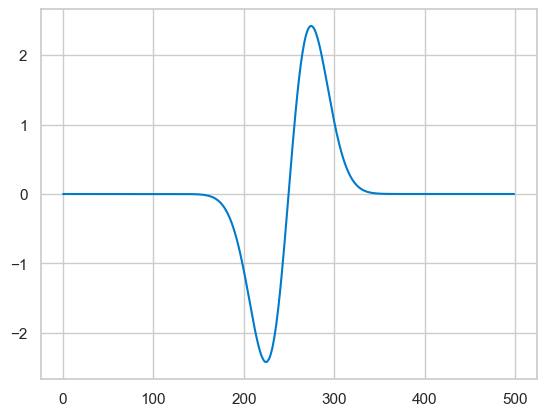

In [6]:
DT = 1e-4


device=torch.device("cpu")
X = torch.linspace(-1, 1, 500, requires_grad=True, device=device).view(-1, 1)


def leftmoving(x, t, sigma=0.1):
    # Apply periodic boundary conditions
    x = (x + t) % 2.0
    x = torch.where(x > 1.0, x - 2.0, x)  # Wrap values greater than 1 back to -1
    return 0.1 / (sigma * torch.sqrt(2.0 * torch.tensor(torch.pi))) * torch.exp(-0.5 * (x / sigma) ** 2)
def rightmoving(x, t, sigma=0.1):
    # Apply periodic boundary conditions
    x = (x - t) % 2.0
    x = torch.where(x > 1.0, x - 2.0, x)  # Wrap values greater than 1 back to -1
    return 0.1 / (sigma * torch.sqrt(2.0 * torch.tensor(torch.pi))) * torch.exp(-0.5 * (x / sigma) ** 2)
# def IC1(X,DT=DT):
#     return (rightmoving(X,torch.tensor([DT]))-rightmoving(X,torch.tensor([0])))/DT +(leftmoving(X,torch.tensor([DT]))-leftmoving(X,torch.tensor([0])))/DT
def IC1(X,DT=DT):
    return (rightmoving(X,torch.tensor([DT]))-rightmoving(X,torch.tensor([0])))/DT 
# def IC1(X,DT=DT):
#     return X*torch.tensor([0])
# T=torch.linspace(0,1,20)
plt.plot(IC1(X,DT).detach())
plt.show()
# plt.plot(exactanswer(X.detach(),torch.tensor([0.5])))

# # Compute IC1 using PyTorch's autograd
# ic1_result = IC1(X, DT)
# ic1_result.backward(torch.ones(ic1_result.size()))
# plt.plot(ic1_result.detach().numpy())
# plt.show()

#### Code

In [1]:
import torch.nn as nn
# Define your neural network model
class EDNN(nn.Module):
    def __init__(self):
        super(EDNN, self).__init__()
        self.L=10
        self.firstlayer=nn.Linear(2,self.L)#,bias=False)

        # self.linmiddle = nn.Linear(1, 10)
        
        self.lin1 = nn.Linear(self.L, self.L)
        self.lin2 = nn.Linear(self.L, self.L)
        self.lin3 = nn.Linear(self.L, self.L)
        self.lin4 = nn.Linear(self.L, 1)
        self.lin5 = nn.Linear(1, 1)

        self.swish1 = nn.SiLU()
        self.swish2 = nn.SiLU()
        self.swish3 = nn.SiLU()
        self.swish4 = nn.SiLU()

    def forward(self, x):
        sinx = torch.sin(torch.pi *x)
        cosx = torch.cos(torch.pi *x)
        input=torch.cat((sinx,cosx),dim=1)
        x=self.firstlayer(input)

        # x=torch.exp((self.linmiddle(x))**2)


        x=self.swish1(self.lin1(x))
        x=self.swish2(self.lin2(x))
        x=self.swish3(self.lin3(x))
        x=self.swish4(self.lin4(x))
        x=self.lin5(x)
        return x



# Define your initial condition function (IC)
# DT=1e-9

#Gaussian Initial Condition
def IC(x,t=0,sigma=0.1):
    return .1 / (sigma * torch.sqrt(torch.tensor([2 * torch.pi], device=device))) * torch.exp(-(x**2) / (2 * sigma**2))

# def IC2(x,t=0,sigma=0.1):
#     return (exactanswer(x,DT) - IC(x))/DT

# plt.plot(X.detach(),IC2(X).detach())
# plt.show()

# Define your N function
def N(u, x):
    return D(u,x,2)

#Exact Answer
def exactanswer(x, t, sigma=0.1):
    # Apply periodic boundary conditions
    x = (x - t) % 2.0
    x = torch.where(x > 1.0, x - 2.0, x)  # Wrap values greater than 1 back to -1
    return 0.1 / (sigma * torch.sqrt(2.0 * torch.tensor(torch.pi))) * torch.exp(-0.5 * (x / sigma) ** 2)

# def IC(x, t=0, sigma=0.1):
#     return -torch.sin(torch.pi*x)

# print(IC(X))
# print(D(IC(X,t=torch.tensor([0])),t))

# plt.plot(exactanswer(solver.X,1.2).detach())
# Create an instance of the EDNN class
Model = EDNN()
Model=Model.to(device)

# Create an instance of the Pi model (Auxiliary field)
Pi = EDNN()
Pi=Pi.to(device)

# Create an instance of the EDNNSolver class
solver = EDNNSolver(
    model=Model,
    Pi=Pi,
    IC=IC,
    N=N,
    exactanswer=exactanswer,
    num_points=100,
    left_boundary=-1.0,
    right_boundary=1.0,
    final_time=1.,
    num_epochs=10000,
    learning_rate=0.001,
    print_interval=100,
    device="cpu",
    evol_method="Euler",
    save_all_functions=False,
    init_print_number=2,
    tol=1e-5
)

# Initialize once
solver.initialize()
solver.initialize(solver.Pi,IC1)

# Store the initial model state
import copy
initial_model_state = copy.deepcopy(solver.Model.state_dict())  # Use deepcopy to create a deep copy
initial_pi_state = copy.deepcopy(solver.Pi.state_dict())  # Use deepcopy to create a deep copy



# Define a list of dt values to run the solver for
dt_values = [1e-3]#, 0.0001]  # Add the dt values you want to test

# Initialize lists to store errors for each run
errors_list = []
losses_list = []

# Run the solver for different dt values
for dt in dt_values:
    print("Evolving for dt= ",dt)
    # Restore the initial model state
    solver.Model.load_state_dict(initial_model_state)
    solver.Pi.load_state_dict(initial_pi_state)

    # print(solver.initial_error)
    # Set the new dt value
    solver.dt = dt

    # Evolve the solver
    solver.evolve()

    # Save errors and losses
    errors_list.append(solver.errors)
    # losses_list.append(solver.losses)


NameError: name 'device' is not defined

### Example Plot

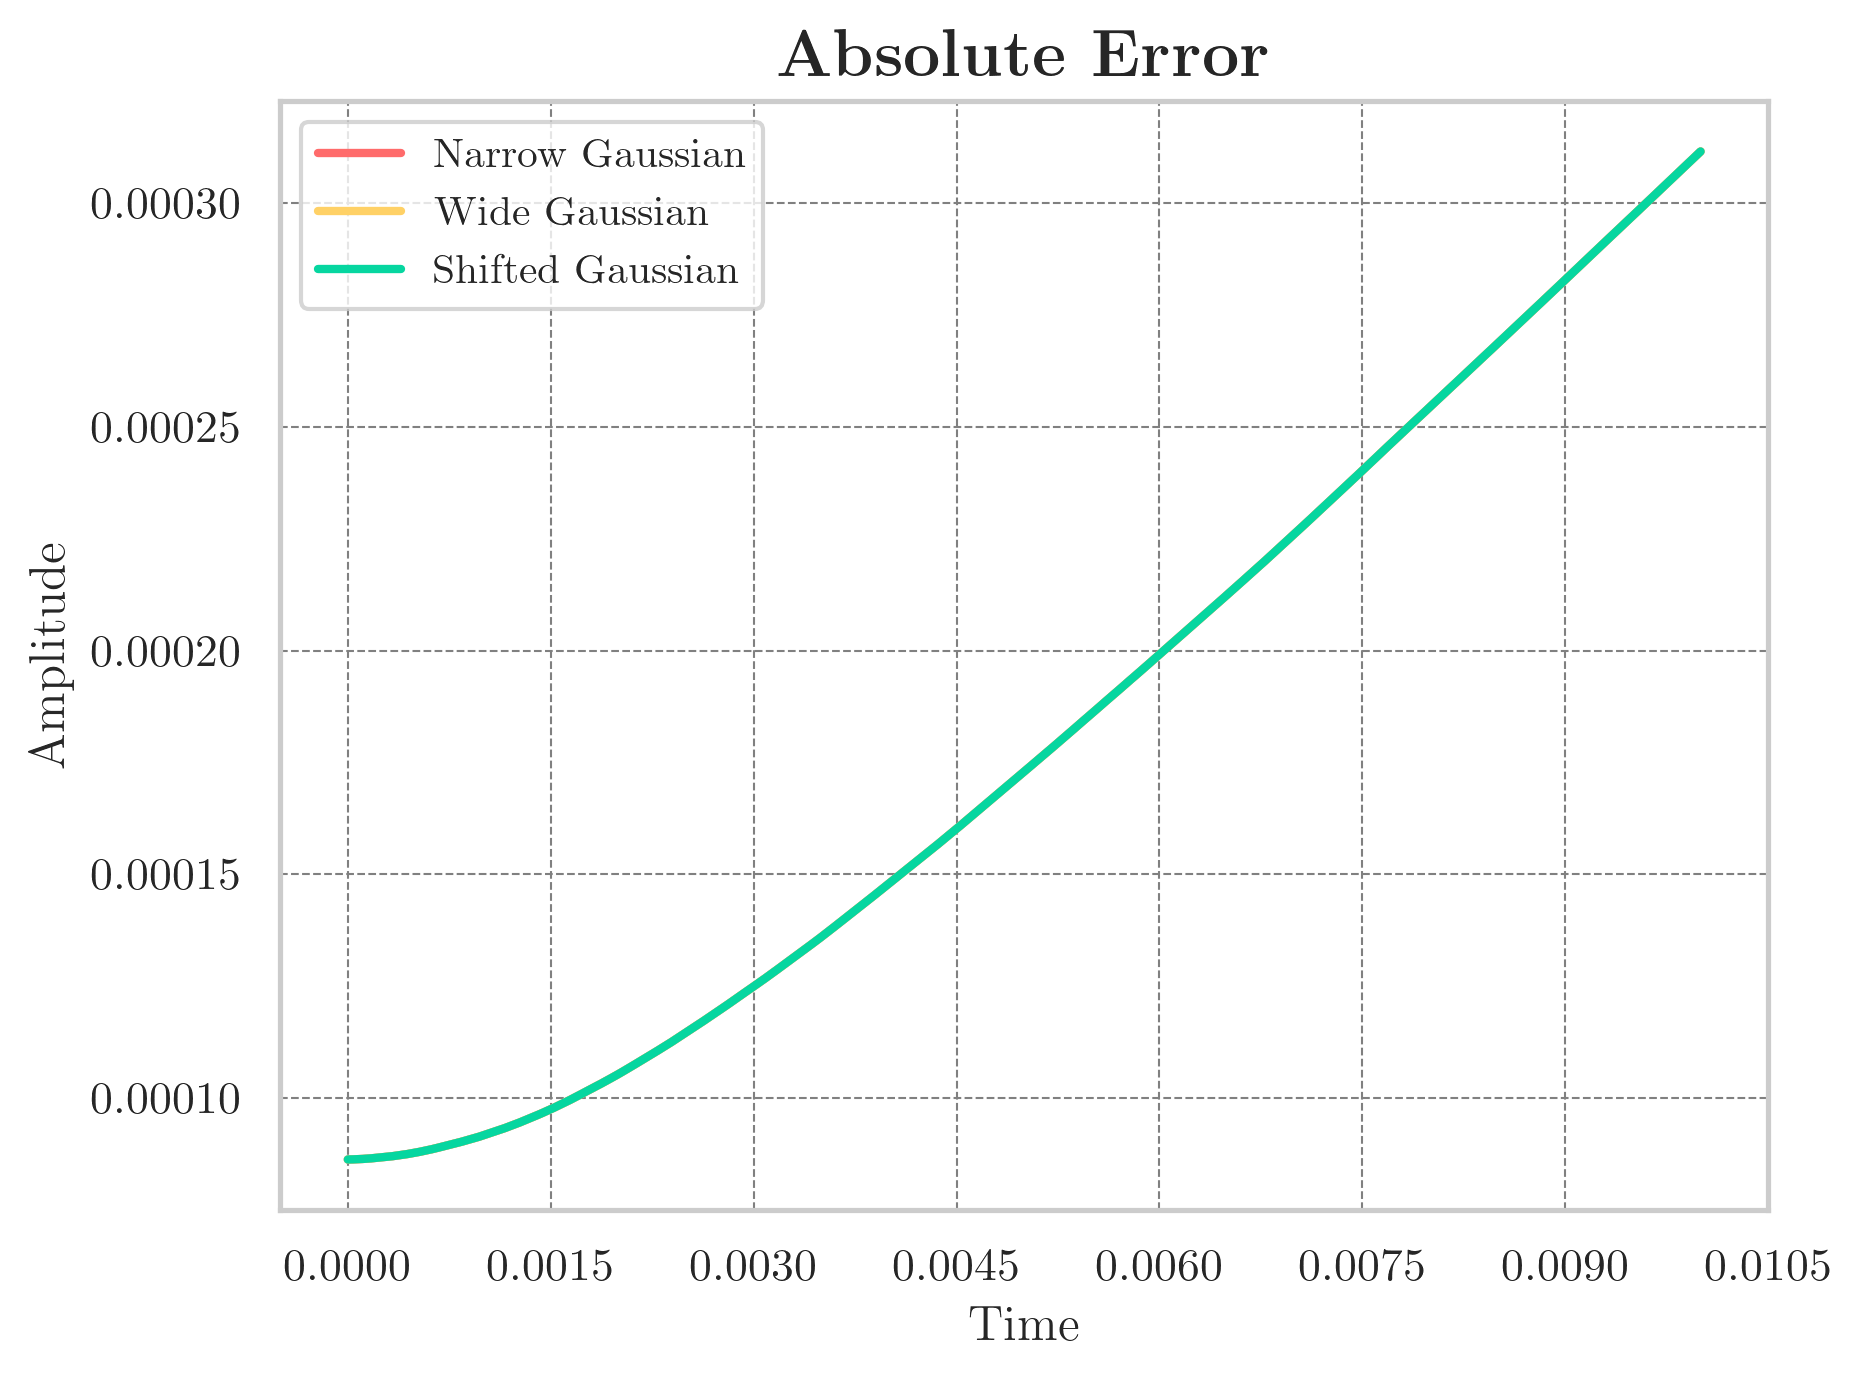

In [ ]:
import numpy as np

# Example 3: Gaussian Distributions (Narrow, Wide, and Shifted)
t_plot = np.linspace(0, 1e-2, 1000)
e1 = errors_list[0].detach()
e2 = errors_list[1].detach()
e3 = errors_list[2].detach()
labels3 = ['Narrow Gaussian', 'Wide Gaussian', 'Shifted Gaussian']

# Create and display the plots
# create_scientific_plot(x, [y1, y2, y3], labels1, 'Trigonometric Functions', 'Time (s)', 'Amplitude', save_plot=False, dpi=300, colors=custom_colors_pastel)
# create_scientific_plot(x, [y4, y5, y6], labels2, 'Exponential and Linear Functions', 'Time (s)', 'Amplitude', save_plot=False, dpi=300, colors=custom_colors_pastel)
create_scientific_plot(t_plot, [y7, y7, y7], labels3, 'Absolute Error', 'Time', 'Amplitude', save_plot=True, dpi=300, color=True, line_style=False,marker_size=.1)
